In [ ]:
!pip install datasketch
!pip install mido
!pip install pretty_midi

In [ ]:
import mido as md
from mido import Message
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import variable
from sklearn.preprocessing import MinMaxScaler
import random as rnd
import pretty_midi
import collections
from torch.utils import data
import os
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from datasketch import MinHash, MinHashLSH
import sys
import pickle

### Data import and preprocessing, with diff calculation

In [ ]:
def extractMessages(midi_file: str, features_to_drop = []):
    pm = pretty_midi.PrettyMIDI(midi_file)
    notes = collections.defaultdict(list)
    for instrument in pm.instruments:
        if(not instrument.is_drum): # filter out drum instruments
            # Sort the notes by start time inside the instrument
            sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
            prev_start = sorted_notes[0].start

            for note in sorted_notes:
                start = note.start
                end = note.end
                notes['note'].append(note.pitch)
                notes['start'].append(start)
                notes['end'].append(end)
                notes['step'].append(start - prev_start) # step = midi event timing, delta time relative to previous event
                notes['duration'].append(end - start)
                notes['program'].append(instrument.program)
                prev_start = start
            
    # sort all notes by start time before resulting DF
    result = pd.DataFrame({name: np.array(value) for name, value in notes.items()})
    result = result.sort_values(by=['start'], ignore_index=True).reset_index(drop=True)
    diff = []
    for i in range(len(result["note"])-1 , 0, -1):
          diff.insert(0,result["note"][i] - result["note"][i-1])
    diff.insert(0,result["note"][0]) # first note diff is it's distance from 0.
    result["diff"] = diff

    return result.drop(features_to_drop, axis = 1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
midi_dir = '/content/drive/MyDrive/Data Science project/Data/GAN/'
midi_files = os.listdir(midi_dir)

In [ ]:
file_diffs = [[] for i in range(len(midi_files))]
for i, song in enumerate(midi_files):
    file_diffs[i] = list(extractMessages(midi_dir + song, features_to_drop=[])["diff"][0:256]) # cut first 256 notes

### Compute inverse of LLCS (1/Lenght of Longes Common Subsequence)

In [ ]:
def lcs_length(a, b):
    table = [[0] * (len(b) + 1) for _ in range(len(a) + 1)] # init dynamic programming matrix with zeroes.
    for i, ca in enumerate(a, 1):
        for j, cb in enumerate(b, 1):
            table[i][j] = (
                table[i - 1][j - 1] + 1 if ca == cb else # no break in subsequence, lengths increases by 1
                max(table[i][j - 1], table[i - 1][j])) # break in subsequence, take the longest found up until now.
    if table[-1][-1] == 0: # 1/0 => distance is infinity
        return sys.maxsize
    
    return 1/(table[-1][-1]) # take the inverse of the length for clustering (smaller number means closer relation between instances)

In [ ]:
hash_mem = {} # cache previously calculated results to shorten runtimes.

def llcs(file_diffs, song1 ,song2):
    
    if song1==song2:
        return 0
    
    song1_diffs = file_diffs[song1]
    song1_name = midi_files[song1]
    
    song2_diffs = file_diffs[song2]
    song2_name = midi_files[song2]
    
    minimum = min(song1,song2)
    maximum = max(song1,song2)
    
    if (minimum,maximum) not in hash_mem.keys(): # cache miss
        result = lcs_length(song1_diffs,song2_diffs)
        hash_mem[(minimum,maximum)] = result
        return result
    
    return hash_mem[(minimum,maximum)] # cache hit

In [ ]:
llcs_results = np.zeros((len(midi_files), len(midi_files)))

In [ ]:
read_from_pickle = True # this notebook was previously executed, we saved a pickle file to shorten runtime on future executions.
if not read_from_pickle:
    for i in range(len(midi_files)):
        for j in range(len(midi_files)):
            llcs_results[i][j] = llcs(file_diffs, i,j)

In [ ]:
if not read_from_pickle:
    pickle.dump(llcs_results, open("/content/drive/MyDrive/Data Science project/Data/mat_1058files_256notes.pickle", "wb"))
else:
    llcs_results = pickle.load(open("/content/drive/MyDrive/Data Science project/Data/mat_1058files_256notes.pickle", "rb"))

In [ ]:
llcs_results

array([[0.        , 0.01724138, 0.01694915, ..., 0.01818182, 0.01351351,
        0.01666667],
       [0.01724138, 0.        , 0.01612903, ..., 0.01818182, 0.01086957,
        0.01785714],
       [0.01694915, 0.01612903, 0.        , ..., 0.01818182, 0.01428571,
        0.015625  ],
       ...,
       [0.01818182, 0.01818182, 0.01818182, ..., 0.        , 0.01470588,
        0.01587302],
       [0.01351351, 0.01086957, 0.01428571, ..., 0.01470588, 0.        ,
        0.01612903],
       [0.01666667, 0.01785714, 0.015625  , ..., 0.01587302, 0.01612903,
        0.        ]])

### Cluster using hierachial clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
song_clusters = AgglomerativeClustering(n_clusters = None, distance_threshold=0.015625, affinity="precomputed", linkage="average")
# 1/64 = 0.015625 is the threshold for stopping
clusetr_indices = song_clusters.fit_predict(llcs_results)
song_clustered = pd.DataFrame(columns = ["song","cluster"])
song_clustered["song"] = midi_files
song_clustered["cluster"] = clusetr_indices

song_clustered

,song,cluster
0,BJ_Thomas_-_Raindrops_Keep_Falling.mid,4
1,B'Witched_-_Blame_It_On_The_Weatherman.mid,4
2,B'Witched_-_Cest_La_Vie.mid,1
3,B'Witched_-_Jesse_Hold_On.mid,4
4,B'Witched_-_Jump_Down.mid,1
...,...,...
1053,Aretha_Franklin_-_You_Make_Me_Feel_Like_a_Natu...,10
1054,The_Association_-_Never_My_Love.mid,4
1055,The_Association_-_Windy.mid,0
1056,BB_Mak_-_Back_Here.mid,4


In [ ]:
# print final clusters
for i in range(song_clustered["cluster"].max() + 1):
    print("Cluster %d contains %d:" %(i, len(song_clustered[song_clustered["cluster"] == i]["song"])))
    print(song_clustered[song_clustered["cluster"] == i]["song"])
    print("-----------------------")

Cluster 0 contains 10:
63       Ben_Folds_Five_-_Steven's_Last_Night_in_Town.mid
177                         Carly_Simon_-_Mockingbird.mid
250                               The_Corrs_-_Someday.mid
297     Dionne_Warwick_-_I'll_Never_Fall_in_Love_Again...
417               Hugh_Masakela_-_Grazin_in_the_Grass.mid
588                          No_Doubt_-_Ex_Girlfriend.mid
635            Paul_McCartney_-_No_More_Lonely_Nights.mid
850                       Tom_Jones_-_Love_Me_Tonight.mid
878                         Usher_-_You_Make_Me_Wanna.mid
1055                          The_Association_-_Windy.mid
Name: song, dtype: object
-----------------------
Cluster 1 contains 524:
2                            B'Witched_-_Cest_La_Vie.mid
4                              B'Witched_-_Jump_Down.mid
5                                B'Witched_-_Lets_Go.mid
6                        Babyface_-_Change_the_World.mid
7                        B'Witched_-_To_You_I_Belong.mid
                              ...     

### Visualize results - we can see the common subsequences in the diffs

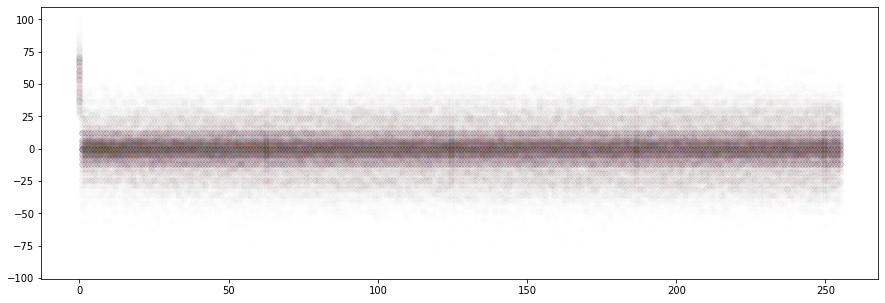

In [ ]:
cluster1 = song_clustered[song_clustered["cluster"] == 1].index
plt.figure(figsize=(15, 5))
for i in cluster1:
    plt.scatter(range(len(file_diffs[i])), file_diffs[i], alpha = 0.002);

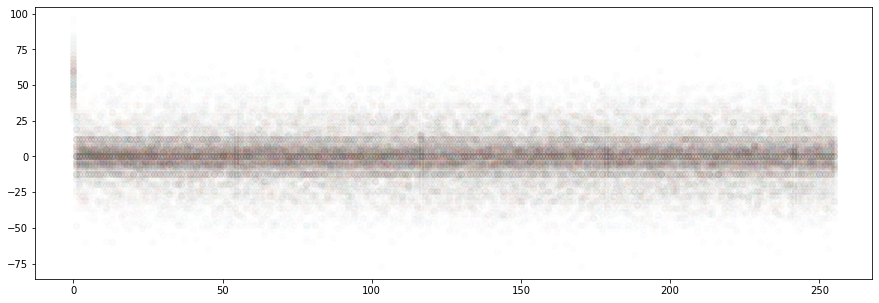

In [ ]:
cluster4 = song_clustered[song_clustered["cluster"] == 4].index
plt.figure(figsize=(15, 5))
for i in cluster4:
    plt.scatter(range(len(file_diffs[i])), file_diffs[i], alpha = 0.01);

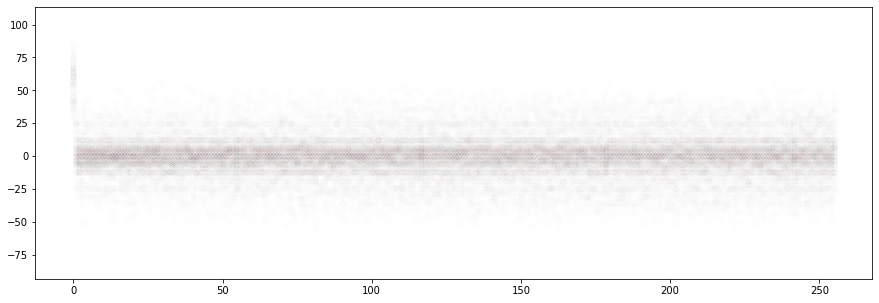

In [ ]:
cluster16 = song_clustered[song_clustered["cluster"] == 16].index
plt.figure(figsize=(15, 5))
for i in cluster16:
    plt.scatter(range(len(file_diffs[i])), file_diffs[i], alpha = 0.002);

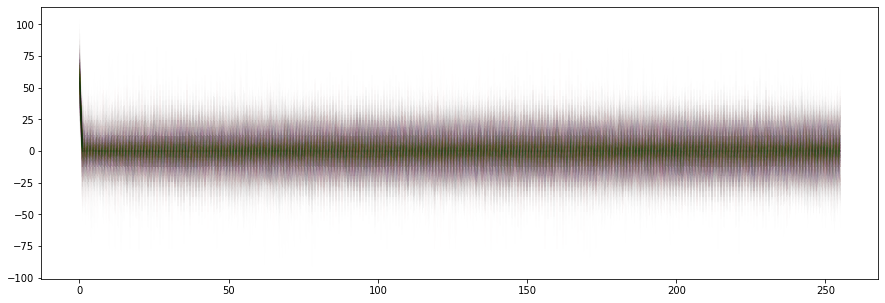

In [ ]:
plt.figure(figsize=(15, 5))
for i in range(len(file_diffs)):
    plt.plot(range(len(file_diffs[i])), file_diffs[i], alpha = 0.005);

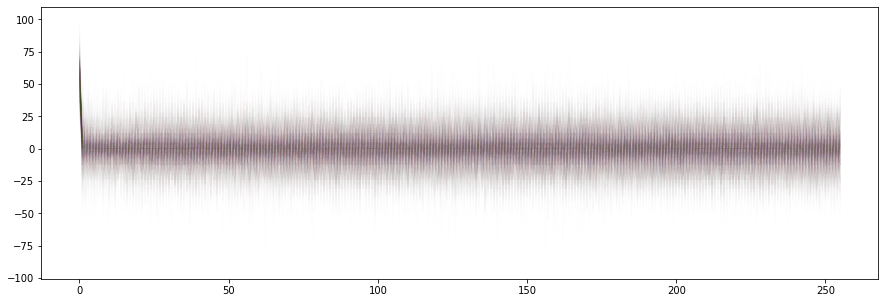

In [ ]:
plt.figure(figsize=(15, 5))
for i in cluster1:
    plt.plot(range(len(file_diffs[i])), file_diffs[i], alpha = 0.005);

In [ ]:
song_clustered[song_clustered["cluster"] == 1]

,song,cluster
2,B'Witched_-_Cest_La_Vie.mid,1
4,B'Witched_-_Jump_Down.mid,1
5,B'Witched_-_Lets_Go.mid,1
6,Babyface_-_Change_the_World.mid,1
7,B'Witched_-_To_You_I_Belong.mid,1
...,...,...
1040,Andrew_Lloyd_Webber_-_Jesus_Christ_Superstar.mid,1
1043,Anne_Murray_-_You_Needed_Me.mid,1
1049,Aretha_Franklin_-_Pink_Cadillac.mid,1
1050,Aretha_Franklin_-_Respect.mid,1


In [ ]:
import shutil
def createClusterdFolders(songs_df, start_dir):
    try:
        os.mkdir(start_dir)
    except:
        print("Cannot create dir:" + start_dir)
    original_path = midi_dir
    known_clusters = {}
    for i in songs_df.iterrows():
        print(i[1]["song"])
        cluster_dir = 'cluster' + str(i[1]["cluster"])
        target_path = start_dir + '/' + cluster_dir +'/'
        if(cluster_dir not in known_clusters.keys()):
            known_clusters[cluster_dir] = 1
            try:
                os.mkdir(target_path)
            except:
                print("Cannot create dir:" + start_dir)
        songs_name = i[1]["song"]
        shutil.copyfile(original_path + str(songs_name) , target_path + str(songs_name))

In [ ]:
createClusterdFolders(song_clustered, "/content/drive/MyDrive/Data Science project/Data/byCluster555-2")

BJ_Thomas_-_Raindrops_Keep_Falling.mid
B'Witched_-_Blame_It_On_The_Weatherman.mid
B'Witched_-_Cest_La_Vie.mid
B'Witched_-_Jesse_Hold_On.mid
B'Witched_-_Jump_Down.mid
B'Witched_-_Lets_Go.mid
Babyface_-_Change_the_World.mid
B'Witched_-_To_You_I_Belong.mid
Babyface_-_Every_Time_I_Close_My_Eyes.mid
Babyface_-_The_Day.mid
Babyface_-_When_Can_I_See_You_Again.mid
Backstreet_Boys_-_Anywhwere_for_You.mid
Backstreet_Boys_-_All_I_Have_to_Give.mid
Backstreet_Boys_-_As_Long_As_You_Love_Me.mid
Backstreet_Boys_-_Back_to_Your_Heart.mid
Backstreet_Boys_-_Everybody.mid
Backstreet_Boys_-_I_Need_You_Tonight.mid
Backstreet_Boys_-_I_Want_It_That_Way.mid
Backstreet_Boys_-_I'll_Never_Break_Your_Heart.mid
Backstreet_Boys_-_Larger_Than_Life.mid
Backstreet_Boys_-_Let_the_Music_Heal_Your_Soul.mid
Backstreet_Boys_-_Like_A_Child.mid
Backstreet_Boys_-_My_Heart_Stays_With_You.mid
Backstreet_Boys_-_No_One_Else_Comes_Close.mid
Backstreet_Boys_-_Quit_Playing_Games_With_My_Heart.mid
Backstreet_Boys_-_Shape_of_My_Heart.mi